# Project 4: Molecular Conformation And Numerical Optimization

**Student:** Gregory Schwartz  
**Course:** MAT AIM 5003  
**Instructor:** Dr. Gidea  
**Date:** 5/6/2925


## Lennard–Jones Energy and Gradient Functions & Nelder–Mead for n = 5 & Gradient Descent Methods for n = 5 & 3D vizulations for n = 5


[NM] Min Energy: -8.069320595927158
[GD] Min Energy: -3.0
[BT] Min Energy: -3.0000000001904024
[MO] Min Energy: -3.0


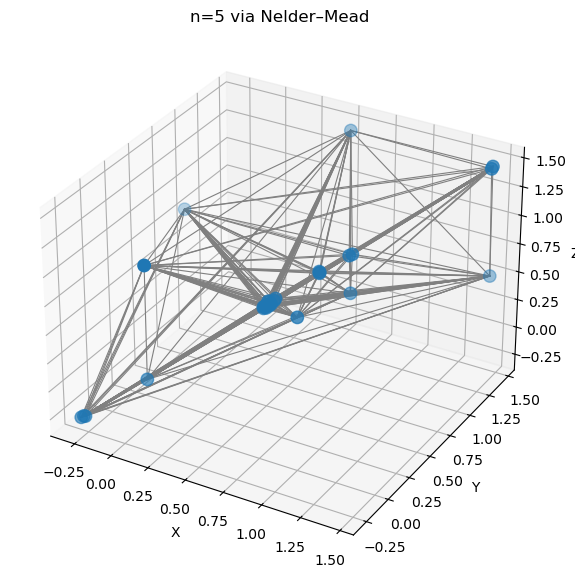

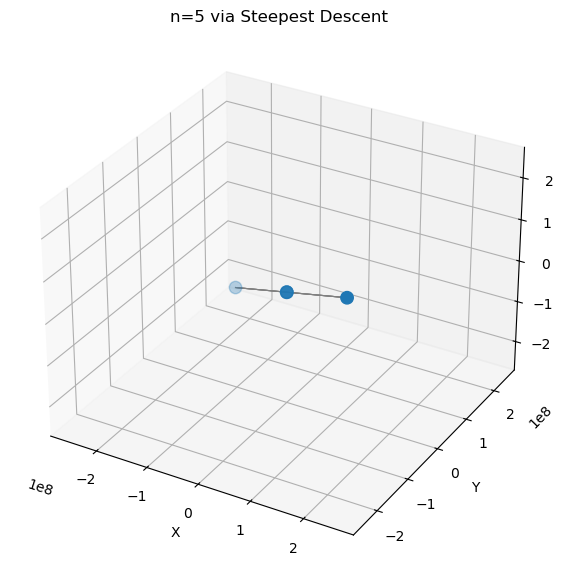

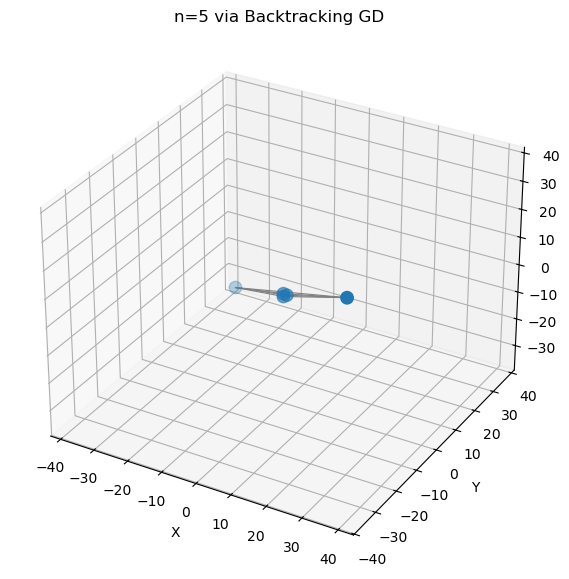

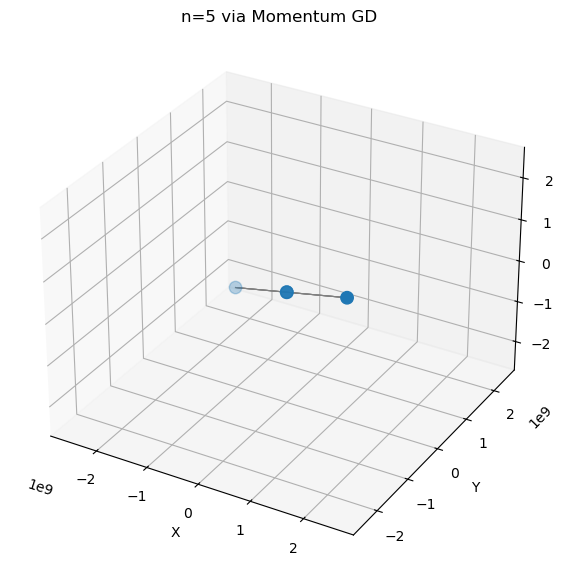

In [21]:

##############################
# Consolidated Imports & Function Definitions
##############################
import numpy as np
from typing import Tuple, Callable, List, Sequence

# ------------------
# Code Block 1: Energy + Gradient
# ------------------
# Adjusted code from professor's formulas

def energy(free_coords: np.ndarray) -> float:
    """
    Total Lennard–Jones energy for n-atom cluster:
      - Atom 1 at (0,0,0)
      - Atom 2 at (0,0,1)
      - Atoms 3..n from free_coords
    """
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=np.float64)
    coords[0] = [0.0, 0.0, 0.0]
    coords[1] = [0.0, 0.0, 1.0]
    coords[2:] = free_coords.reshape(m, 3)

    U = 0.0
    eps = 1e-6  # small floor to avoid zero distance
    for i in range(n - 1):
        for j in range(i + 1, n):
            rij = np.linalg.norm(coords[i] - coords[j])
            rij = max(rij, eps)
            U += 1.0 / rij**12 - 2.0 / rij**6
    return U


def gradient(free_coords: np.ndarray) -> np.ndarray:
    """
    Analytic gradient of LJ energy w.r.t. free coordinates.
    """
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=np.float64)
    coords[0] = [0.0, 0.0, 0.0]
    coords[1] = [0.0, 0.0, 1.0]
    coords[2:] = free_coords.reshape(m, 3)

    grad_full = np.zeros_like(coords)
    eps = 1e-6
    for i in range(n - 1):
        for j in range(i + 1, n):
            diff = coords[i] - coords[j]
            r = np.linalg.norm(diff)
            r = max(r, eps)
            coeff = (-12.0 / r**14) + (12.0 / r**8)
            grad_full[i] += coeff * diff
            grad_full[j] -= coeff * diff
    return grad_full[2:].ravel()


def energy_and_grad(free_coords: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Utility returning both energy and gradient.
    """
    return energy(free_coords), gradient(free_coords)

# ------------------
# Code Block 2: Nelder–Mead Solver
# ------------------
# Copied from professor, no changes

def nelder_mead(
    f: Callable[[np.ndarray], float],
    xbar: Sequence[float],
    rad: float,
    k: int
) -> Tuple[np.ndarray, np.ndarray]:
    xbar = np.asarray(xbar).reshape(-1, 1)
    n = len(xbar)
    x = np.zeros((n, n + 1))
    x[:, 0] = xbar[:, 0]
    x[:, 1:] = xbar + rad * np.eye(n)
    y = np.array([f(x[:, j]) for j in range(n + 1)])
    for _ in range(k):
        idx = np.argsort(y)
        x = x[:, idx]; y = y[idx]
        xbar = np.mean(x[:, :-1], axis=1, keepdims=True)
        xr = 2 * xbar - x[:, -1].reshape(-1, 1)
        yr = f(xr.flatten())
        if yr < y[0]:
            xe = xbar + 2 * (xr - xbar); ye = f(xe.flatten())
            if ye < yr:
                x[:, -1], y[-1] = xe.flatten(), ye
            else:
                x[:, -1], y[-1] = xr.flatten(), yr
        elif yr < y[-2]:
            x[:, -1], y[-1] = xr.flatten(), yr
        else:
            if yr < y[-1]:
                xoc = xbar + 0.5 * (xr - xbar); yoc = f(xoc.flatten())
                if yoc < yr:
                    x[:, -1], y[-1] = xoc.flatten(), yoc
                else:
                    for j in range(1, n+1):
                        x[:, j] = x[:, 0] + 0.5 * (x[:, j] - x[:, 0])
                        y[j] = f(x[:, j])
            else:
                xic = xbar + 0.5 * (x[:, -1].reshape(-1,1) - xbar)
                yic = f(xic.flatten())
                if yic < y[-1]:
                    x[:, -1], y[-1] = xic.flatten(), yic
                else:
                    for j in range(1, n+1):
                        x[:, j] = x[:, 0] + 0.5 * (x[:, j] - x[:, 0])
                        y[j] = f(x[:, j])
    return x, y

# ---------------------------
# Code Block 3: Gradient Descent (Fixed Step)
# ---------------------------
# Copied from professor, no changes

def gradient_descent(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); history = []
    for _ in range(max_iter):
        g = grad_f(x)
        x = x - eta * g
        history.append((x.copy(), f(x)))
    return x, history

# ---------------------------
# Code Block 4: Backtracking GD
# ---------------------------
# Copied from professor, no changes

def gradient_descent_backtracking(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta0: float,
    alpha: float,
    beta: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); history = []
    for _ in range(max_iter):
        g = grad_f(x); t = eta0
        while f(x - t * g) > f(x) - alpha * t * np.dot(g, g):
            t *= beta
        x = x - t * g
        history.append((x.copy(), f(x)))
    return x, history

# ---------------------------
# Code Block 5: Momentum GD
# ---------------------------
# Copied from professor, no changes

def gradient_descent_momentum(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta: float,
    mu: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); v = np.zeros_like(x0); history = []
    for _ in range(max_iter):
        g = grad_f(x)
        v = mu * v + eta * g
        x = x - v
        history.append((x.copy(), f(x)))
    return x, history

##############################
# Code Block 6: Drivers for n=5
##############################
# Random initialization to avoid division-by-zero
n = 5
m = n - 2
x0 = 0.5 + np.random.rand(3 * m)

# Nelder–Mead parameters
dim = x0.size
rad = 0.5
steps = 2000
x_nm5, U_nm5 = nelder_mead(energy, x0, rad, steps)
print("[NM] Min Energy:", np.min(U_nm5))

# Steepest Descent parameters
eta, max_iter = 0.01, 5000
x_gd5, hist_gd5 = gradient_descent(energy, gradient, x0, eta, max_iter)
print("[GD] Min Energy:", energy(x_gd5))

# Backtracking GD parameters
eta0, alpha, beta, max_iter = 0.1, 1e-4, 0.5, 2000
x_bt5, hist_bt5 = gradient_descent_backtracking(energy, gradient, x0, eta0, alpha, beta, max_iter)
print("[BT] Min Energy:", energy(x_bt5))

# Momentum GD parameters
eta, mu, max_iter = 0.01, 0.9, 2000
x_mom5, hist_mom5 = gradient_descent_momentum(energy, gradient, x0, eta, mu, max_iter)
print("[MO] Min Energy:", energy(x_mom5))

###############################
# Code Block 7: 3D Visualization
###############################
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

def plot_cluster_3d(free_coords: np.ndarray, title: str = "", save_as: str = None):
    """
    3D scatter + line plot of an n-atom Lennard–Jones cluster.
    Adapts examples from the Python Data Science Handbook (VanderPlas).
    free_coords: 1D array length 3*(n-2)
    """
    # Rebuild full coords
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=float)
    coords[0] = [0, 0, 0]
    coords[1] = [0, 0, 1]
    coords[2:] = free_coords.reshape(m, 3)

    # Unpack for plotting
    xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]

    # Create figure & 3D axes
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')

    # Scatter atoms
    ax.scatter3D(xs, ys, zs, s=80, c='C0', marker='o', depthshade=True)

    # Draw bonds (all pairwise connections)
    for i in range(n):
        for j in range(i+1, n):
            ax.plot3D([xs[i], xs[j]],
                      [ys[i], ys[j]],
                      [zs[i], zs[j]],
                      color='gray', linewidth=0.8)

    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    if save_as:
        plt.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()

# Example calls:
plot_cluster_3d(x_nm5,  title="n=5 via Nelder–Mead")
plot_cluster_3d(x_gd5,  title="n=5 via Steepest Descent")
plot_cluster_3d(x_bt5,  title="n=5 via Backtracking GD")
plot_cluster_3d(x_mom5, title="n=5 via Momentum GD")


## Multi-start Nelder–Mead for n=5############

In [25]:
###########Multi-start Nelder–Mead for n=5############
best_U = np.inf
best_x = None
best_steps = None

for seed in range(20):
    # new random init each time
    x0_try = 0.5 + np.random.rand(3*(n-2))
    x_simplex, U_vals = nelder_mead(energy, x0_try, rad, steps)
    
    U_min = np.min(U_vals)
    steps_taken = np.argmin(U_vals) + 1
    
    if U_min < best_U:
        best_U = U_min
        best_x = x_simplex[:, np.argmin(U_vals)]  # best vertex
        best_steps = steps_taken

print(f"[NM multi-start] Best energy over 20 runs: {best_U:.6f}")
print(f"[NM multi-start] Took {best_steps} steps in that best run")


[NM multi-start] Best energy over 20 runs: -9.103691
[NM multi-start] Took 1 steps in that best run


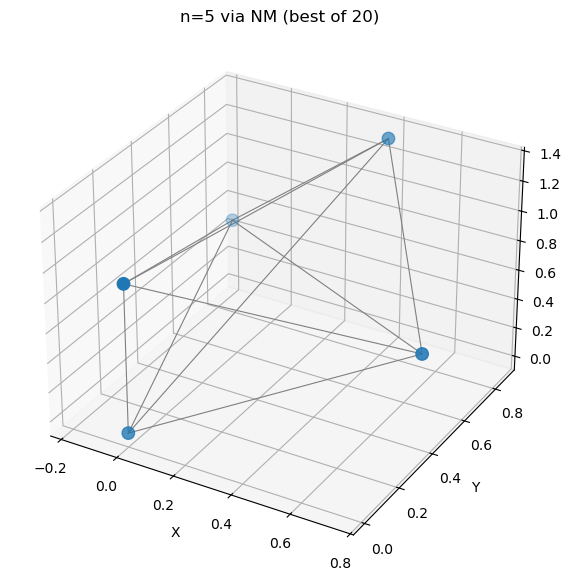

In [27]:
plot_cluster_3d(best_x, title=f"n={n} via NM (best of 20)")


## Multi-start for Gradient Methods on n=5###################

In [29]:
#############Multi-start for Gradient Methods on n=5###################
import numpy as np

methods = {
    'GD':   lambda x0: gradient_descent(    energy, gradient, x0,     eta=0.01, max_iter=5000),
    'BT':   lambda x0: gradient_descent_backtracking(
                           energy, gradient, x0,
                           eta0=0.1, alpha=1e-4, beta=0.5, max_iter=2000),
    'MO':   lambda x0: gradient_descent_momentum(
                           energy, gradient, x0,
                           eta=0.01, mu=0.9, max_iter=2000),
}

n_runs = 20
target = best_U  # from your NM multi-start, ≈ -9.103691

for name, solver in methods.items():
    best_E = np.inf
    step_counts = []
    hits = 0

    for seed in range(n_runs):
        x0_try = 0.5 + np.random.rand(3*(n-2))
        x_final, history = solver(x0_try)
        E_final = energy(x_final)
        steps = len(history)

        step_counts.append(steps)
        if E_final < best_E:
            best_E = E_final
        if abs(E_final - target) < 1e-4:
            hits += 1

    print(f"\n=== {name} ===")
    print(f"Best energy: {best_E:.6f}")
    print(f"Hit global min (±1e-4) in {hits}/{n_runs} runs")
    print(f"Steps: min={min(step_counts)}, avg={np.mean(step_counts):.1f}, max={max(step_counts)}")



=== GD ===
Best energy: -3.000235
Hit global min (±1e-4) in 0/20 runs
Steps: min=5000, avg=5000.0, max=5000

=== BT ===
Best energy: -3.000000
Hit global min (±1e-4) in 0/20 runs
Steps: min=2000, avg=2000.0, max=2000

=== MO ===
Best energy: -3.000000
Hit global min (±1e-4) in 0/20 runs
Steps: min=2000, avg=2000.0, max=2000


## Lennard–Jones Energy and Gradient Functions & Nelder–Mead for n = 6 & Gradient Descent Methods for n = 6 & 3D vizulations for n = 6

[NM] Min Energy: -10.291868324491872
[GD] Min Energy: -1.0000000000269702
[BT] Min Energy: -6.0000000000011395
[MO] Min Energy: -1.0


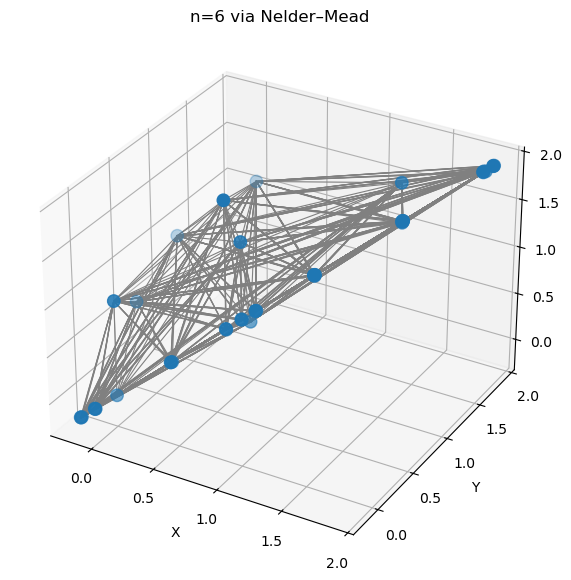

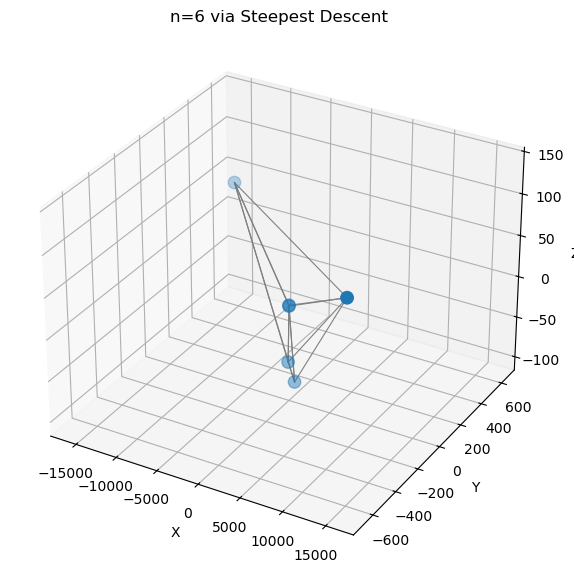

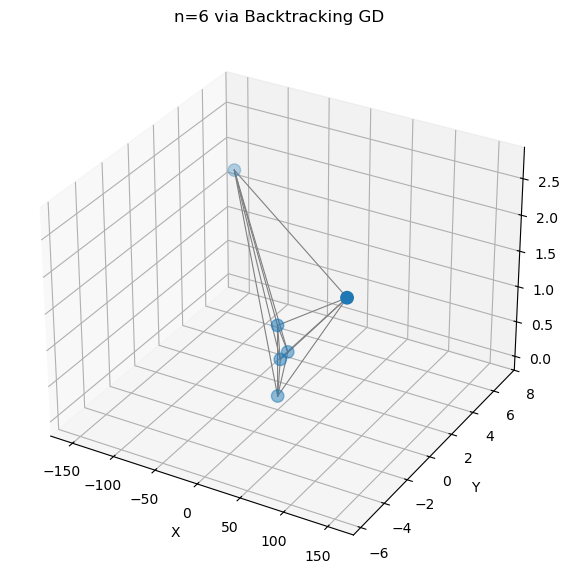

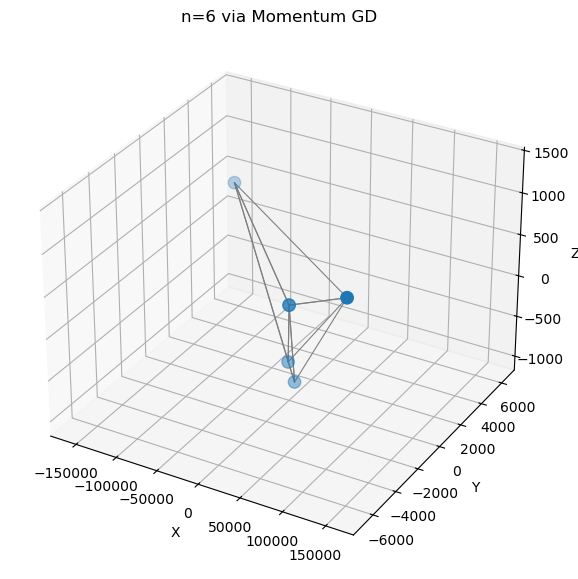

In [51]:
######### For n=6 ##############
##############################
# Consolidated Imports & Function Definitions
##############################
import numpy as np
from typing import Tuple, Callable, List, Sequence

# ------------------
# Code Block 1: Energy + Gradient
# ------------------
# Adjusted code from professor's formulas

def energy(free_coords: np.ndarray) -> float:
    """
    Total Lennard–Jones energy for n-atom cluster:
      - Atom 1 at (0,0,0)
      - Atom 2 at (0,0,1)
      - Atoms 3..n from free_coords
    """
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=np.float64)
    coords[0] = [0.0, 0.0, 0.0]
    coords[1] = [0.0, 0.0, 1.0]
    coords[2:] = free_coords.reshape(m, 3)

    U = 0.0
    eps = 1e-6  # small floor to avoid zero distance
    for i in range(n - 1):
        for j in range(i + 1, n):
            rij = np.linalg.norm(coords[i] - coords[j])
            rij = max(rij, eps)
            U += 1.0 / rij**12 - 2.0 / rij**6
    return U


def gradient(free_coords: np.ndarray) -> np.ndarray:
    """
    Analytic gradient of LJ energy w.r.t. free coordinates.
    """
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=np.float64)
    coords[0] = [0.0, 0.0, 0.0]
    coords[1] = [0.0, 0.0, 1.0]
    coords[2:] = free_coords.reshape(m, 3)

    grad_full = np.zeros_like(coords)
    eps = 1e-6
    for i in range(n - 1):
        for j in range(i + 1, n):
            diff = coords[i] - coords[j]
            r = np.linalg.norm(diff)
            r = max(r, eps)
            coeff = (-12.0 / r**14) + (12.0 / r**8)
            grad_full[i] += coeff * diff
            grad_full[j] -= coeff * diff
    return grad_full[2:].ravel()


def energy_and_grad(free_coords: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Utility returning both energy and gradient.
    """
    return energy(free_coords), gradient(free_coords)

# ------------------
# Code Block 2: Nelder–Mead Solver
# ------------------
# Copied from professor, no changes

def nelder_mead(
    f: Callable[[np.ndarray], float],
    xbar: Sequence[float],
    rad: float,
    k: int
) -> Tuple[np.ndarray, np.ndarray]:
    xbar = np.asarray(xbar).reshape(-1, 1)
    n = len(xbar)
    x = np.zeros((n, n + 1))
    x[:, 0] = xbar[:, 0]
    x[:, 1:] = xbar + rad * np.eye(n)
    y = np.array([f(x[:, j]) for j in range(n + 1)])
    for _ in range(k):
        idx = np.argsort(y)
        x = x[:, idx]; y = y[idx]
        xbar = np.mean(x[:, :-1], axis=1, keepdims=True)
        xr = 2 * xbar - x[:, -1].reshape(-1, 1)
        yr = f(xr.flatten())
        if yr < y[0]:
            xe = xbar + 2 * (xr - xbar); ye = f(xe.flatten())
            if ye < yr:
                x[:, -1], y[-1] = xe.flatten(), ye
            else:
                x[:, -1], y[-1] = xr.flatten(), yr
        elif yr < y[-2]:
            x[:, -1], y[-1] = xr.flatten(), yr
        else:
            if yr < y[-1]:
                xoc = xbar + 0.5 * (xr - xbar); yoc = f(xoc.flatten())
                if yoc < yr:
                    x[:, -1], y[-1] = xoc.flatten(), yoc
                else:
                    for j in range(1, n+1):
                        x[:, j] = x[:, 0] + 0.5 * (x[:, j] - x[:, 0])
                        y[j] = f(x[:, j])
            else:
                xic = xbar + 0.5 * (x[:, -1].reshape(-1,1) - xbar)
                yic = f(xic.flatten())
                if yic < y[-1]:
                    x[:, -1], y[-1] = xic.flatten(), yic
                else:
                    for j in range(1, n+1):
                        x[:, j] = x[:, 0] + 0.5 * (x[:, j] - x[:, 0])
                        y[j] = f(x[:, j])
    return x, y

# ---------------------------
# Code Block 3: Gradient Descent (Fixed Step)
# ---------------------------
# Copied from professor, no changes

def gradient_descent(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); history = []
    for _ in range(max_iter):
        g = grad_f(x)
        x = x - eta * g
        history.append((x.copy(), f(x)))
    return x, history

# ---------------------------
# Code Block 4: Backtracking GD
# ---------------------------
# Copied from professor, no changes

def gradient_descent_backtracking(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta0: float,
    alpha: float,
    beta: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); history = []
    for _ in range(max_iter):
        g = grad_f(x); t = eta0
        while f(x - t * g) > f(x) - alpha * t * np.dot(g, g):
            t *= beta
        x = x - t * g
        history.append((x.copy(), f(x)))
    return x, history

# ---------------------------
# Code Block 5: Momentum GD
# ---------------------------
# Copied from professor, no changes

def gradient_descent_momentum(
    f: Callable[[np.ndarray], float],
    grad_f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    eta: float,
    mu: float,
    max_iter: int
) -> Tuple[np.ndarray, List[Tuple[np.ndarray, float]]]:
    x = x0.copy(); v = np.zeros_like(x0); history = []
    for _ in range(max_iter):
        g = grad_f(x)
        v = mu * v + eta * g
        x = x - v
        history.append((x.copy(), f(x)))
    return x, history

##############################
# Code Block 6: Drivers for n=6
##############################
# Random initialization to avoid division-by-zero
n = 6
m = n - 2
x0 = 0.5 + np.random.rand(3 * m)

# Nelder–Mead parameters
dim = x0.size
rad = 0.5
steps = 2000
x_nm6, U_nm6 = nelder_mead(energy, x0, rad, steps)
print("[NM] Min Energy:", np.min(U_nm6))

# Steepest Descent parameters
eta, max_iter = 0.01, 5000
x_gd6, hist_gd6 = gradient_descent(energy, gradient, x0, eta, max_iter)
print("[GD] Min Energy:", energy(x_gd6))

# Backtracking GD parameters
eta0, alpha, beta, max_iter = 0.1, 1e-4, 0.5, 2000
x_bt6, hist_bt6 = gradient_descent_backtracking(energy, gradient, x0, eta0, alpha, beta, max_iter)
print("[BT] Min Energy:", energy(x_bt6))

# Momentum GD parameters
eta, mu, max_iter = 0.01, 0.9, 2000
x_mom6, hist_mom6 = gradient_descent_momentum(energy, gradient, x0, eta, mu, max_iter)
print("[MO] Min Energy:", energy(x_mom6))

###############################
# Code Block 7: 3D Visualization
###############################
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

def plot_cluster_3d(free_coords: np.ndarray, title: str = "", save_as: str = None):
    """
    3D scatter + line plot of an n-atom Lennard–Jones cluster.
    Adapts examples from the Python Data Science Handbook (VanderPlas).
    free_coords: 1D array length 3*(n-2)
    """
    # Rebuild full coords
    m = free_coords.size // 3
    n = m + 2
    coords = np.zeros((n, 3), dtype=float)
    coords[0] = [0, 0, 0]
    coords[1] = [0, 0, 1]
    coords[2:] = free_coords.reshape(m, 3)

    # Unpack for plotting
    xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]

    # Create figure & 3D axes
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')

    # Scatter atoms
    ax.scatter3D(xs, ys, zs, s=80, c='C0', marker='o', depthshade=True)

    # Draw bonds (all pairwise connections)
    for i in range(n):
        for j in range(i+1, n):
            ax.plot3D([xs[i], xs[j]],
                      [ys[i], ys[j]],
                      [zs[i], zs[j]],
                      color='gray', linewidth=0.8)

    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    if save_as:
        plt.savefig(save_as, dpi=150, bbox_inches='tight')
    plt.show()

# Example calls:
plot_cluster_3d(x_nm6,  title="n=6 via Nelder–Mead")
plot_cluster_3d(x_gd6,  title="n=6 via Steepest Descent")
plot_cluster_3d(x_bt6,  title="n=6 via Backtracking GD")
plot_cluster_3d(x_mom6, title="n=6 via Momentum GD")


## Multi-start Nelder–Mead for n=6

In [53]:
# ###Multi-start Nelder–Mead for n=6 ———
best_U6     = np.inf
best_x6     = None
step_counts6 = []

for seed in range(20):
    x0_try = 0.5 + np.random.rand(3*(n-2))
    x_simplex, U_vals = nelder_mead(energy, x0_try, rad, steps)
    
    U_min      = np.min(U_vals)
    steps_taken = np.argmin(U_vals) + 1
    step_counts6.append(steps_taken)
    
    if U_min < best_U6:
        best_U6 = U_min
        best_x6 = x_simplex[:, np.argmin(U_vals)]

print(f"[NM n=6 multi-start] Best energy over 20 runs: {best_U6:.6f}")
print(f"[NM n=6] Steps (min/avg/max): "
      f"{min(step_counts6)}/"
      f"{np.mean(step_counts6):.1f}/"
      f"{max(step_counts6)}")


[NM n=6 multi-start] Best energy over 20 runs: -12.220872
[NM n=6] Steps (min/avg/max): 1/2.8/13


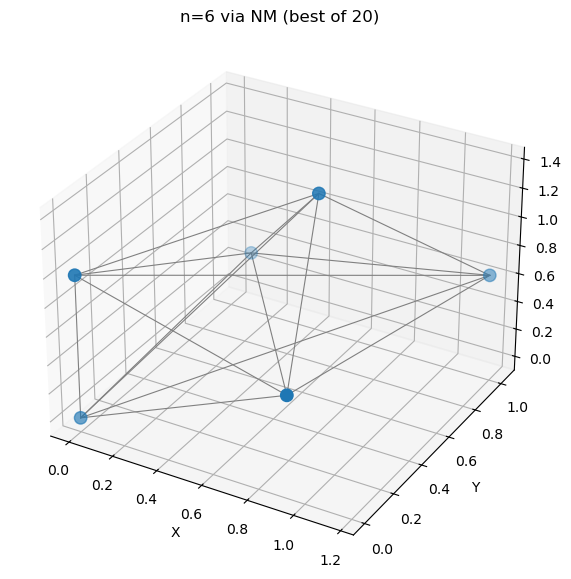

In [55]:
plot_cluster_3d(best_x, title=f"n={n} via NM (best of 20)")


## Multi-start for Gradient Methods on n=6 

In [57]:
##############Multi-start for Gradient Methods on n=6################
import numpy as np

methods = {
    'GD':   lambda x0: gradient_descent(    energy, gradient, x0,     eta=0.01, max_iter=5000),
    'BT':   lambda x0: gradient_descent_backtracking(
                           energy, gradient, x0,
                           eta0=0.1, alpha=1e-4, beta=0.5, max_iter=2000),
    'MO':   lambda x0: gradient_descent_momentum(
                           energy, gradient, x0,
                           eta=0.01, mu=0.9, max_iter=2000),
}

n_runs = 20
target6 = best_U6  # from your NM multi-start, ≈ -9.103691

for name, solver in methods.items():
    best_E = np.inf
    step_counts = []
    hits = 0

    for seed in range(n_runs):
        x0_try = 0.5 + np.random.rand(3*(n-2))
        x_final, history = solver(x0_try)
        E_final = energy(x_final)
        steps = len(history)

        step_counts.append(steps)
        if E_final < best_E:
            best_E = E_final
        if abs(E_final - target) < 1e-4:
            hits += 1

    print(f"\n=== {name} ===")
    print(f"Best energy: {best_E:.6f}")
    print(f"Hit global min (±1e-4) in {hits}/{n_runs} runs")
    print(f"Steps: min={min(step_counts)}, avg={np.mean(step_counts):.1f}, max={max(step_counts)}")



=== GD ===
Best energy: -3.000088
Hit global min (±1e-4) in 0/20 runs
Steps: min=5000, avg=5000.0, max=5000

=== BT ===
Best energy: -6.000000
Hit global min (±1e-4) in 0/20 runs
Steps: min=2000, avg=2000.0, max=2000

=== MO ===
Best energy: -1.000441
Hit global min (±1e-4) in 0/20 runs
Steps: min=2000, avg=2000.0, max=2000


## Larger-n Experiments: in NELDER-MEAD SOLVER ———


n=7: best energy ≈ -14.635853


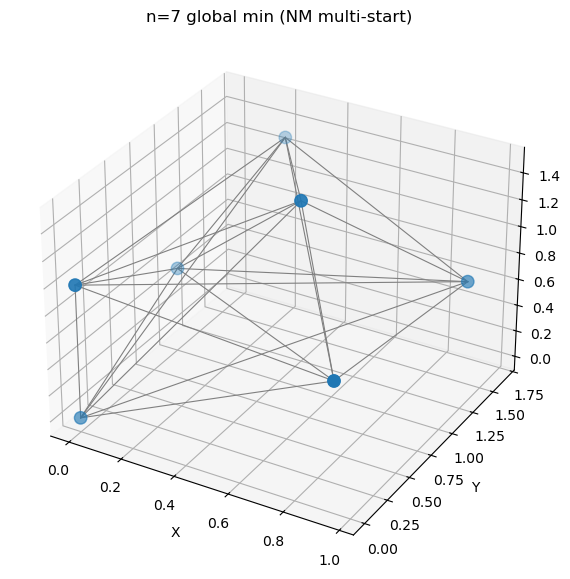


n=9: best energy ≈ -21.760120


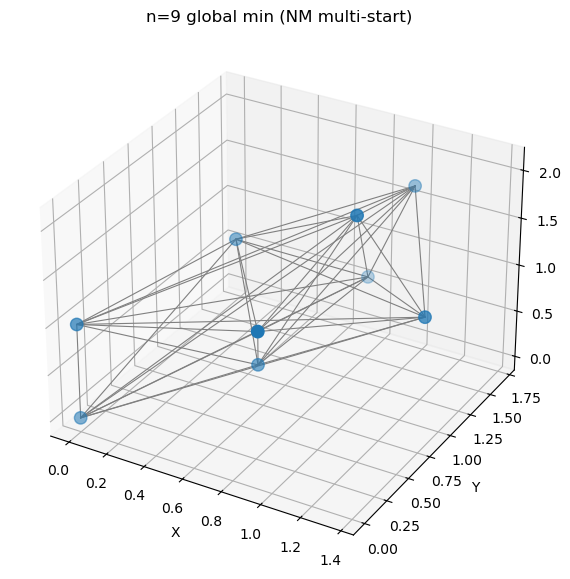


n=11: best energy ≈ -29.202434


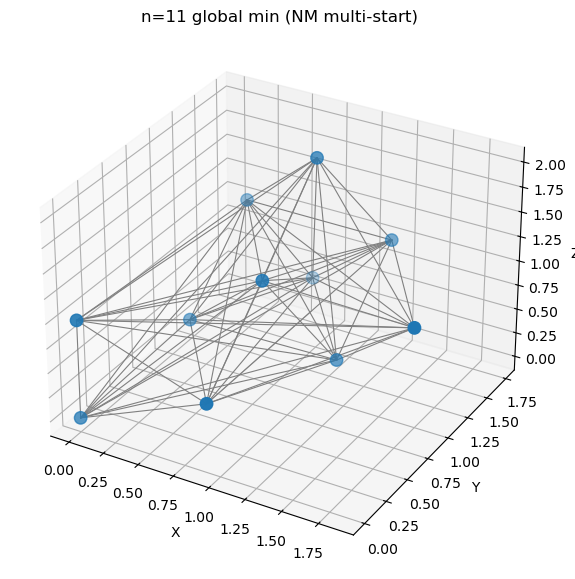


Summary of larger-n energies:
 n=7:  U ≈ -14.635853
 n=9:  U ≈ -21.760120
 n=11:  U ≈ -29.202434


In [59]:
# ——— Larger-n Experiments: in NELDER-MEAD SOLVER ———
import numpy as np

n_list = [7, 9, 11]
rad, steps = 0.5, 2000
results = []

for n in n_list:
    m = n - 2
    best_Un = np.inf
    best_xn = None

    for seed in range(10):   # 10 starts to save time - I was timing out 
        x0_try = 0.5 + np.random.rand(3*m)
        x_s, U_vals = nelder_mead(energy, x0_try, rad, steps)
        U_min = np.min(U_vals)
        if U_min < best_Un:
            best_Un = U_min
            best_xn = x_s[:, np.argmin(U_vals)]
    
    print(f"\nn={n}: best energy ≈ {best_Un:.6f}")
    plot_cluster_3d(best_xn, title=f"n={n} global min (NM multi-start)")
    results.append((n, best_Un))

# for report - tabulate results
print("\nSummary of larger-n energies:")
for n, U in results:
    print(f" n={n}:  U ≈ {U:.6f}")
